<a href="https://colab.research.google.com/github/shriya-0802/KneeArthritis_InceptionV3/blob/main/final_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# ==============================
# Core Libraries
# ==============================
import numpy as np
import pandas as pd
import os
import time
import shutil
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# Scikit-learn
# ==============================
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    roc_auc_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# ==============================
# TensorFlow / Keras
# ==============================
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense,
    Activation,
    Dropout,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    GlobalAveragePooling2D,
    Input
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam, SGD, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
!unzip /content/drive/MyDrive/project/archive (1).zip

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `unzip /content/drive/MyDrive/project/archive (1).zip'


In [7]:
train_path = '/content/drive/MyDrive/project/archive (1)/train'
test_path = '/content/drive/MyDrive/project/archive (1)/test'
valid_path = '/content/drive/MyDrive/project/archive (1)/val'
list_of_classes=['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']


In [8]:
for d in [train_path, test_path, valid_path]:
    filepaths = []
    labels=[]
    classlist=os.listdir(d)
    for klass in classlist:
        intklass=int(klass)
        label=list_of_classes[intklass]
        classpath=os.path.join(d, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(label)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    pdf=pd.concat([Fseries, Lseries], axis=1)
    if d == test_path:
        test_df=pdf
    elif d == valid_path:
        valid_df=pdf
    else:
        train_df=pdf
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  5779   test_df length:  1656   valid_df length:  826
The number of classes in the dataset is:  5
            CLASS               IMAGE COUNT 
           Doubtful                1046     
           Healthy                 2287     
           Minimal                 1516     
           Moderate                 757     
            Severe                  173     
Healthy  has the most images=  2287   Severe  has the least images=  173
average height=  224  average width=  224 aspect ratio=  1.0


In [9]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=500 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=173
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  173


In [10]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df['labels'].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=os.listdir(classpath)
        for f in flist:
          fpath=os.path.join(classpath,f)
          aug_fpaths.append(fpath)
          aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

n=500 # number of samples in each classIncep
working_dir=r'./' # directory to store augmented images
img_size=(224,224) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)

Initial length of dataframe is  2173
Found 173 validated image filenames.
Total Augmented images created=  327
Length of augmented dataframe is now  2500


In [11]:
def relabel(label_in):
    if label_in =='Healthy' or label_in == 'Doubtful' or label_in =='Minimal':
        label='Healthy'
    else:
        label=label_in
    return label


for df in [train_df, test_df, valid_df]:
    for i in range (len(df)):
        label=df['labels'].iloc[i]
        new_label=relabel(label)
        df['labels'].iloc[i]=new_label
print (train_df['labels'].value_counts())

/tmp/ipython-input-2821975925.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['labels'].iloc[i]=new_label


labels
Healthy     1500
Severe       500
Moderate     500
Name: count, dtype: int64


In [12]:
max_samples=500
min_samples=500
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  500


In [13]:
batch_size=20
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='')
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='')
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)


length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='')
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 1500 validated image filenames belonging to 3 classes.
Found 826 validated image filenames belonging to 3 classes.
Found 1656 validated image filenames belonging to 3 classes.
test batch size:  72   test steps:  23  number of classes :  3


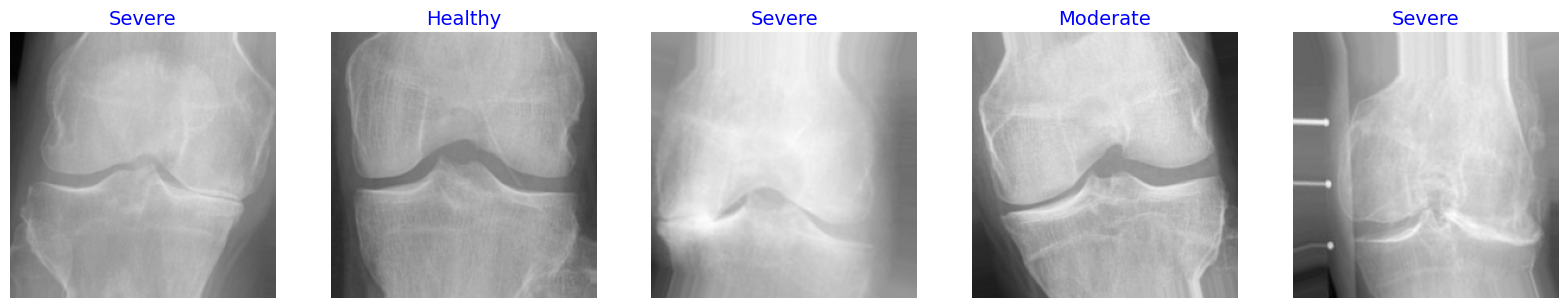

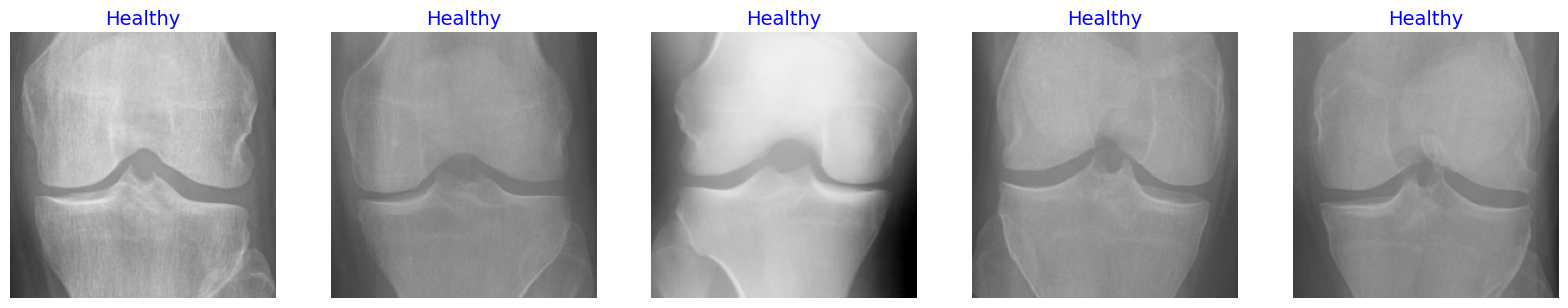

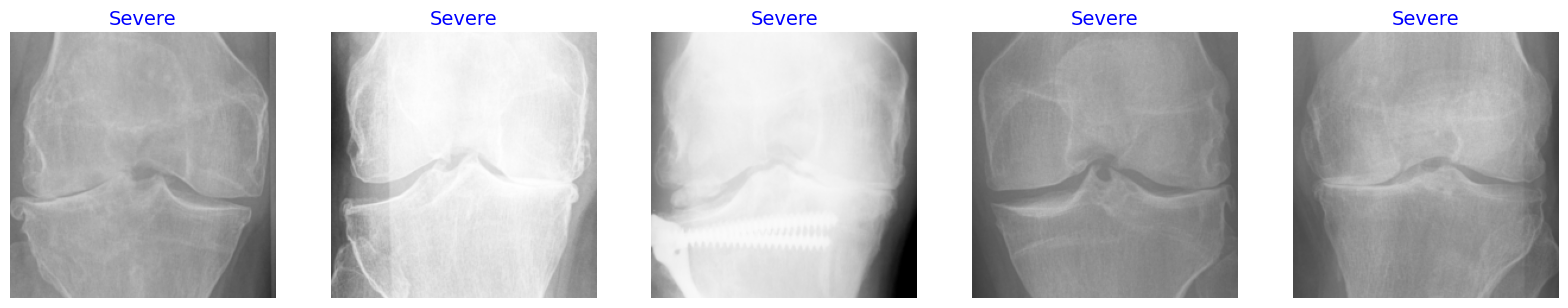

In [14]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<5:   #show maximum of 5 images
        r=length
    else:
        r=5
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )
show_image_samples(test_gen )
show_image_samples(valid_gen )

In [15]:
input_tensor = Input(shape=(224, 224, 3))

base_model = InceptionV3(weights='imagenet',include_top=False,input_shape=(224,224,3), pooling='max')

base_model.trainable=True
x = base_model.output

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(3, activation='softmax')(x)

In [17]:
model=Model(inputs=base_model.input, outputs=output)
lr=.001
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
class LR_ASK(tf.keras.callbacks.Callback):

    def __init__(self, epochs, ask_epoch):
        super().__init__()
        self.ask_epoch = ask_epoch
        self.epochs = epochs
        self.ask = True
        self.lowest_vloss = np.inf
        self.best_weights = None
        self.best_epoch = 1

    def on_train_begin(self, logs=None):

        if self.ask_epoch == 0:
            self.ask_epoch = 1

        if self.ask_epoch >= self.epochs:
            self.ask = False

        if self.epochs == 1:
            self.ask = False

        print(f"Training will run until epoch {self.ask_epoch} before asking.")
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):

        v_loss = logs.get('val_loss')

        if v_loss < self.lowest_vloss:
            self.lowest_vloss = v_loss
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1
            print(f"\nValidation loss improved to {v_loss:.4f}")
        else:
            print(f"\nValidation loss {v_loss:.4f} did not improve")

        if self.ask and (epoch + 1 == self.ask_epoch):

            ans = input("\nEnter H to stop or number of extra epochs: ")

            if ans.lower() in ['h', '0']:
                self.model.stop_training = True
                print("Training stopped by user.")

            else:
                self.ask_epoch += int(ans)
                print(f"Continuing until epoch {self.ask_epoch}")

                lr = float(tf.keras.backend.get_value(
                    self.model.optimizer.learning_rate
                ))

                print(f"Current LR = {lr:.6f}")
                new_lr = input("Press Enter to keep or enter new LR: ")

                if new_lr != '':
                    tf.keras.backend.set_value(
                        self.model.optimizer.learning_rate,
                        float(new_lr)
                    )
                    print(f"LR changed to {new_lr}")

    def on_train_end(self, logs=None):

        if self.best_weights is not None:
            print(f"\nRestoring best weights from epoch {self.best_epoch}")
            self.model.set_weights(self.best_weights)

        duration = time.time() - self.start_time
        print(f"Training finished in {duration/60:.2f} minutes")


In [20]:
epochs = 50
ask_epoch = 50

ask = LR_ASK(epochs, ask_epoch)

callbacks = [ask]

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    callbacks=callbacks
)


Training will run until epoch 50 before asking.
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3584 - loss: 13.8883
Validation loss improved to 92.4807
75/75 ━━━━━━━━━━━━━━━━━━━━ 496s 6s/step - accuracy: 0.3583 - loss: 13.8422 - val_accuracy: 0.1501 - val_loss: 92.4807
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.3407 - loss: 7.6459
Validation loss 653.9452 did not improve
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 450ms/step - accuracy: 0.3408 - loss: 7.6443 - val_accuracy: 0.5726 - val_loss: 653.9452
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.3550 - loss: 7.1095
Validation loss 97.3145 did not improve
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 460ms/step - accuracy: 0.3549 - loss: 7.1078 - val_accuracy: 0.8281 - val_loss: 97.3145
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.3503 - loss: 6.6037
Validation loss improved to 25.4103
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 458ms/step - accuracy: 0.3501 - loss: 6.6021 - val_accuracy: 0.2663 -

In [21]:
new_history = model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0
)

Training will run until epoch 50 before asking.
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.3500 - loss: 1.1329
Validation loss 30.8869 did not improve
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 472ms/step - accuracy: 0.3497 - loss: 1.1329 - val_accuracy: 0.3632 - val_loss: 30.8869
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.3476 - loss: 1.1255
Validation loss 1.3468 did not improve
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 471ms/step - accuracy: 0.3474 - loss: 1.1254 - val_accuracy: 0.0835 - val_loss: 1.3468
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.3146 - loss: 1.1178
Validation loss 1.2418 did not improve
75/75 ━━━━━━━━━━━━━━━━━━━━ 34s 450ms/step - accuracy: 0.3145 - loss: 1.1178 - val_accuracy: 0.1659 - val_loss: 1.2418
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.3407 - loss: 1.1134
Validation loss 1.3782 did not improve
75/75 ━━━━━━━━━━━━━━━━━━━━ 35s 471ms/step - accuracy: 0.3407 - loss: 1.1134 - val_accuracy: 0.08

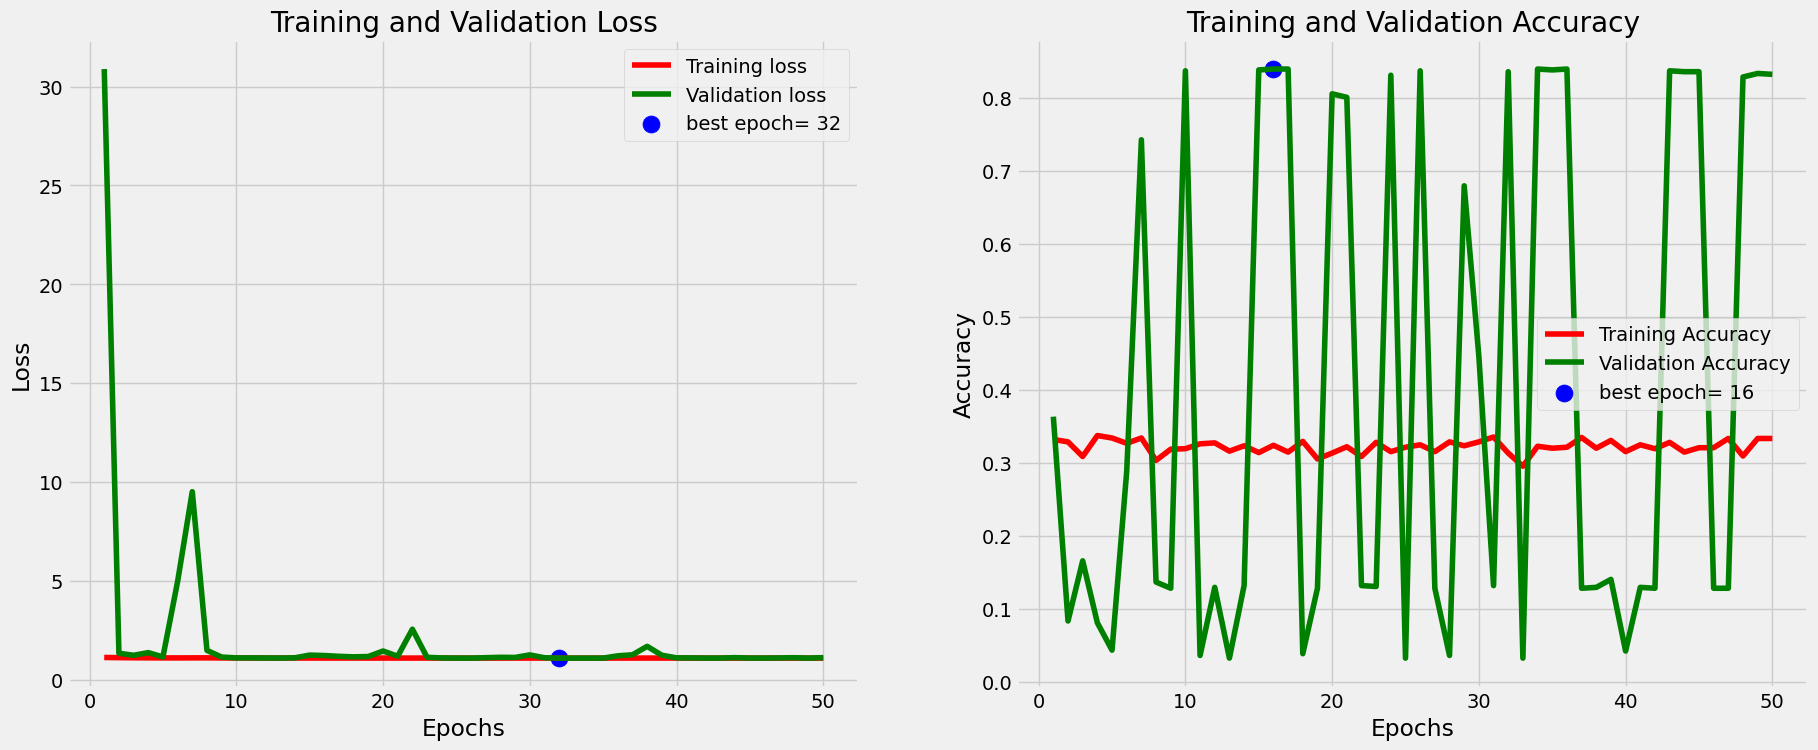

In [23]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

tr_plot(new_history,0)

In [24]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
            file=test_gen.filenames[i]
        y_pred.append(pred_index)

    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests,y_pred

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 406s 18s/step
there were 278 errors in 1656 tests for an accuracy of  83.21


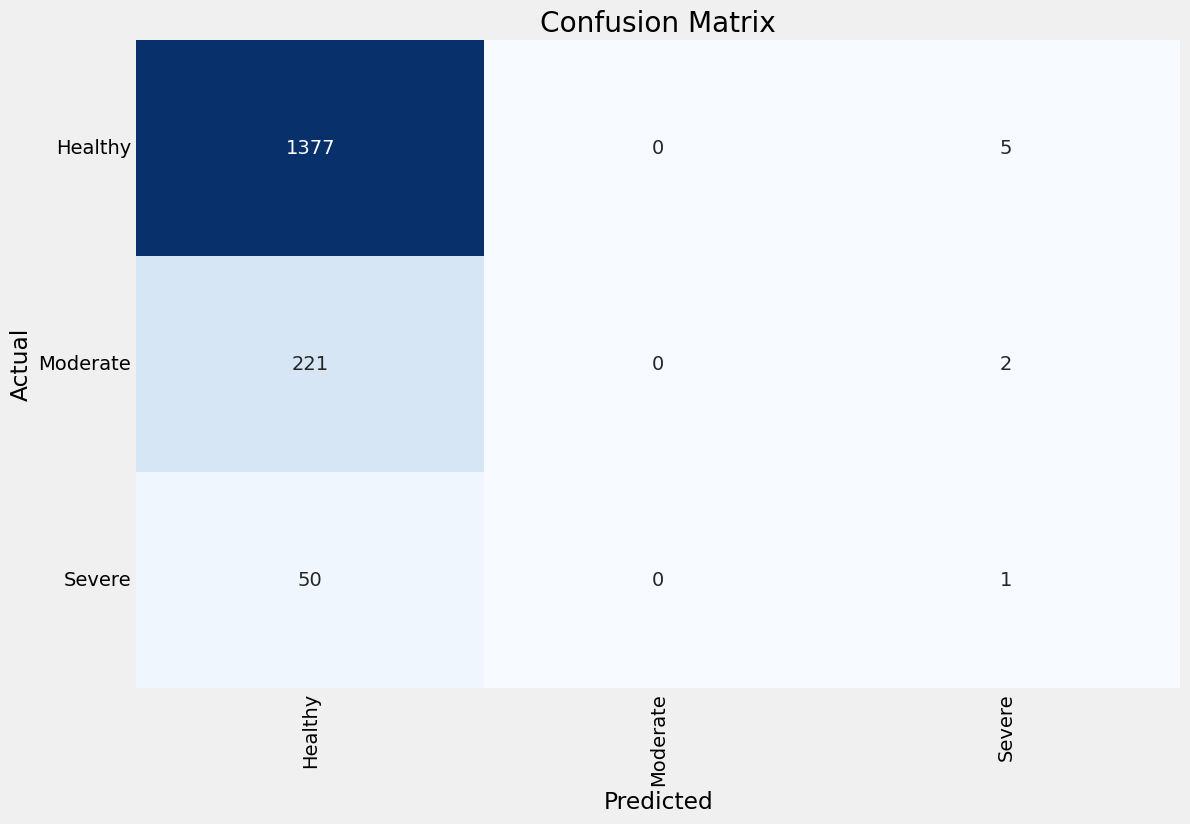

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.8356    0.9964    0.9089      1382
    Moderate     0.0000    0.0000    0.0000       223
      Severe     0.1250    0.0196    0.0339        51

    accuracy                         0.8321      1656
   macro avg     0.3202    0.3387    0.3143      1656
weighted avg     0.7012    0.8321    0.7596      1656



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
errors, tests,y_pred2=predictor(test_gen, test_steps)

ROC AUC score: 0.5037629054204995


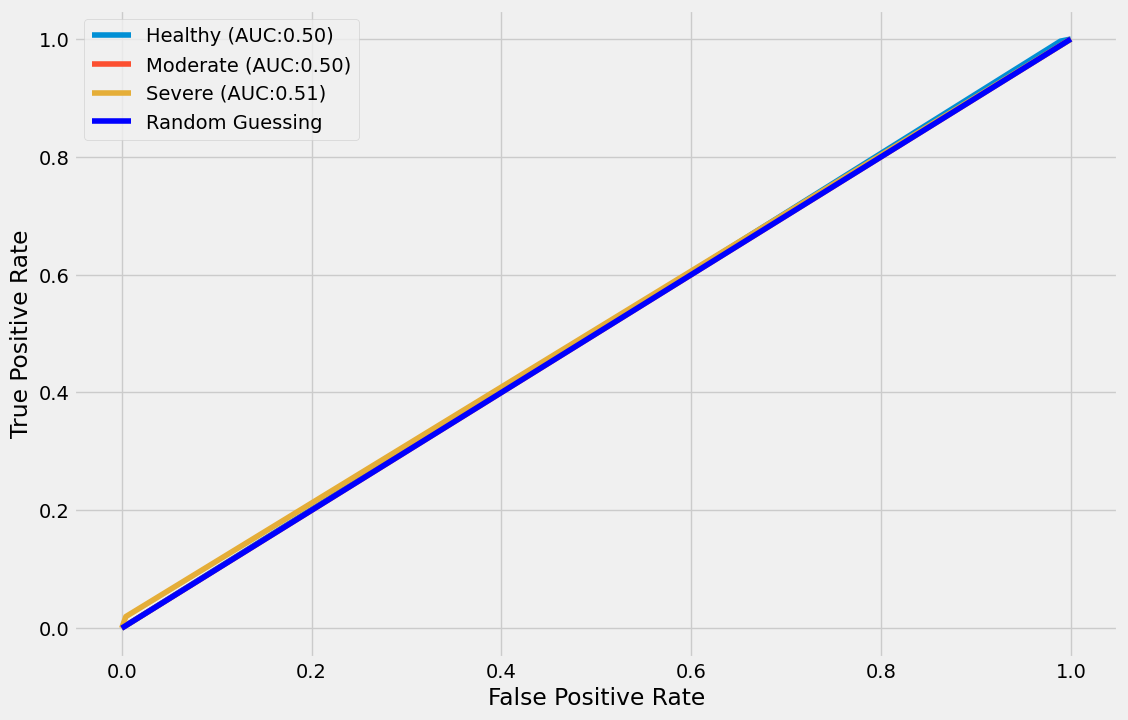

In [26]:
def roc_cur234():
  target= ['Healthy', 'Moderate', 'Severe']

  # set plot figure size
  fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

  # function for scoring roc auc score for multi-class
  def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
      lb = LabelBinarizer()
      lb.fit(y_test)
      y_test = lb.transform(y_test)
      y_pred = lb.transform(y_pred)

      for (idx, c_label) in enumerate(target):
          fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
          c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
      c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
      return roc_auc_score(y_test, y_pred, average=average)


  print('ROC AUC score:', multiclass_roc_auc_score(test_gen.labels, y_pred2))

  c_ax.legend()
  c_ax.set_xlabel('False Positive Rate')
  c_ax.set_ylabel('True Positive Rate')
  plt.show()

roc_cur234()

In [27]:
new_history=model.fit(x=train_gen,  epochs=5, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will run until epoch 50 before asking.
Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.3233 - loss: 1.1009
Validation loss 1.1002 did not improve
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 433ms/step - accuracy: 0.3233 - loss: 1.1009 - val_accuracy: 0.8366 - val_loss: 1.1002
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.3276 - loss: 1.1001
Validation loss 1.1013 did not improve
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 434ms/step - accuracy: 0.3276 - loss: 1.1001 - val_accuracy: 0.8366 - val_loss: 1.1013
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.3082 - loss: 1.1000
Validation loss 3.3319 did not improve
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 436ms/step - accuracy: 0.3081 - loss: 1.1000 - val_accuracy: 0.1283 - val_loss: 3.3319
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.3258 - loss: 1.1019
Validation loss 1.1853 did not improve
75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 430ms/step - accuracy: 0.3258 - loss: 1.1019 - val_accuracy: 0.8390 - v

23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 391ms/step
there were 278 errors in 1656 tests for an accuracy of  83.21


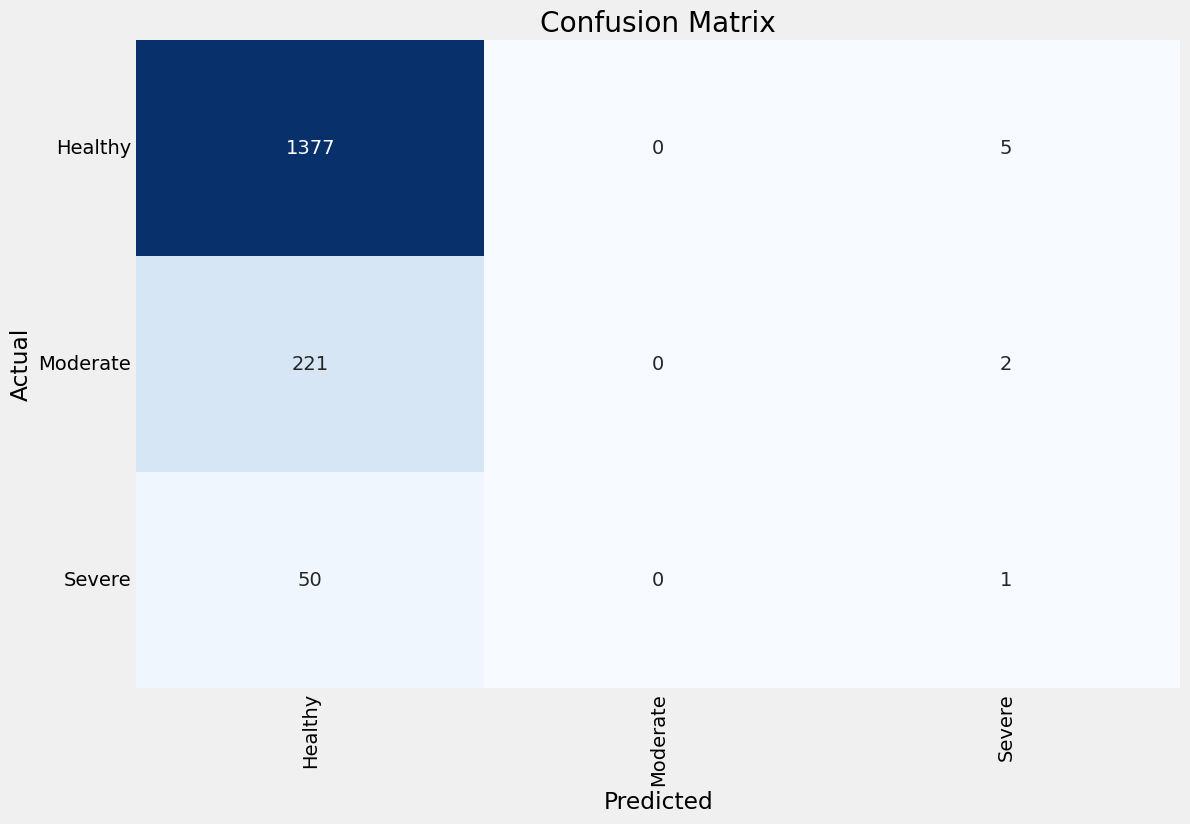

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.8356    0.9964    0.9089      1382
    Moderate     0.0000    0.0000    0.0000       223
      Severe     0.1250    0.0196    0.0339        51

    accuracy                         0.8321      1656
   macro avg     0.3202    0.3387    0.3143      1656
weighted avg     0.7012    0.8321    0.7596      1656



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
errors, tests,y_pred3=predictor(test_gen, test_steps)

ROC AUC score: 0.5037629054204995


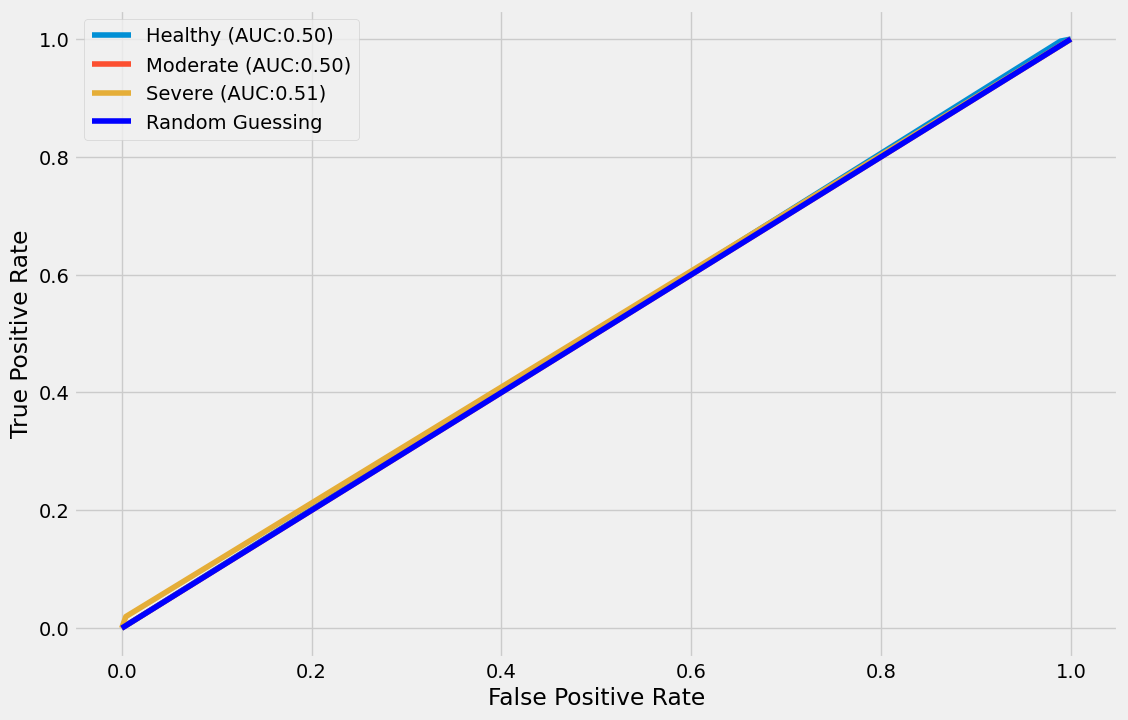

In [29]:
roc_cur234()

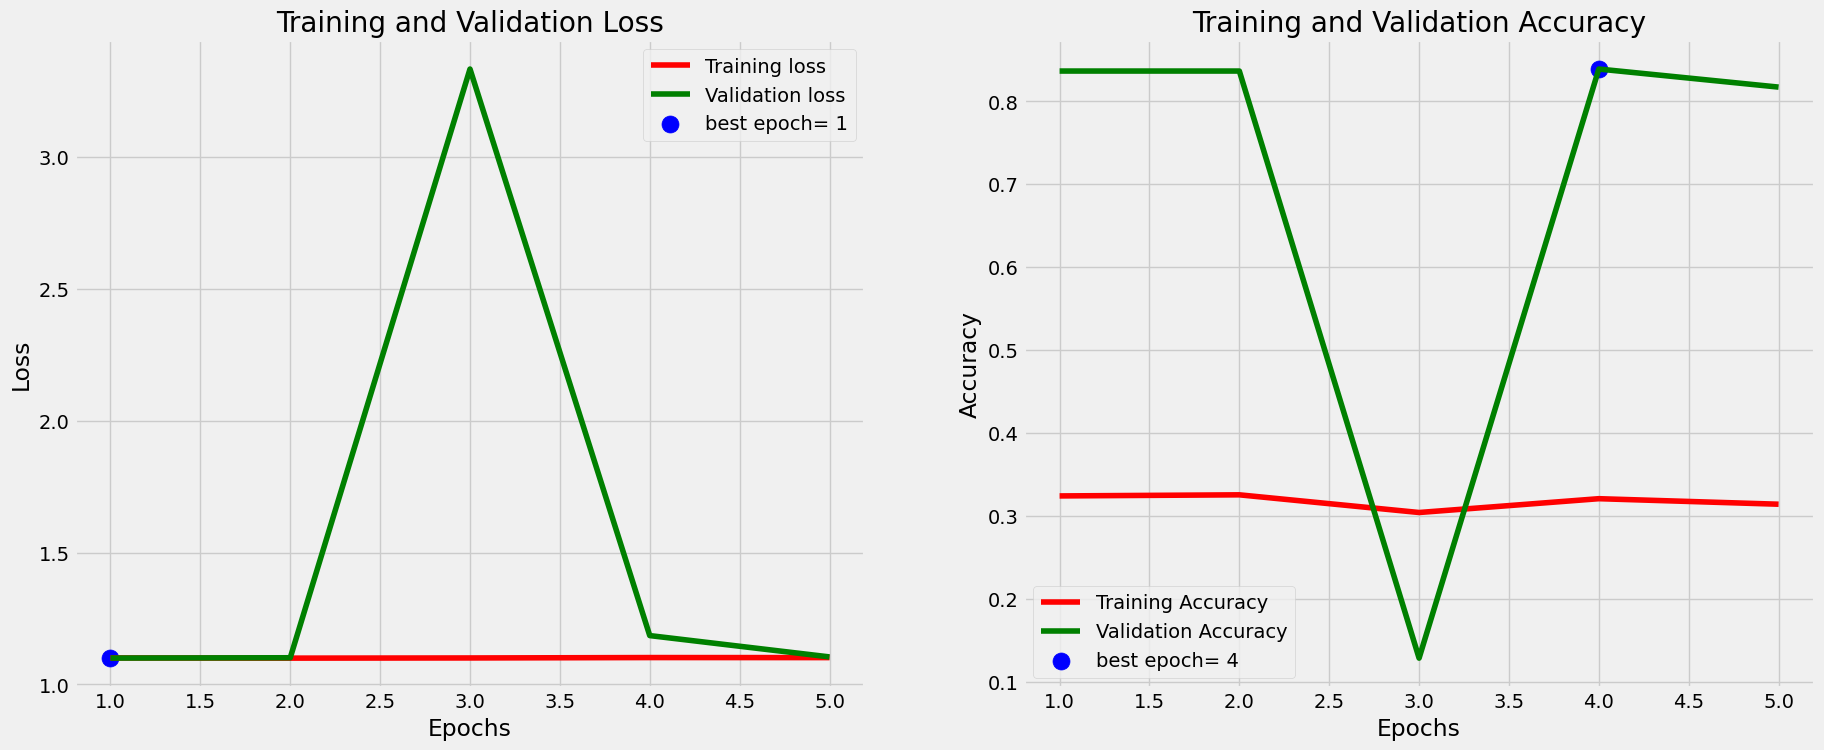

In [30]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

tr_plot(new_history,0)

In [31]:
subject='InceptionV3'
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5'
model_save_loc=os.path.join("/content/drive/MyDrive/Colab Notebooks/", save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc)

model was saved as  /content/drive/MyDrive/Colab Notebooks/InceptionV3_83.21.h5
